# Audio Data Augmentation

In [1]:
#Export 
from exp.nb_AudioCommon import *

In [2]:
#Export
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from fastai import *
from fastai.text import * 
from fastai.vision import *
import torch
import librosa
import torchaudio
from torchaudio import transforms

## IMPORTANT: audio transformations I/O is AudioData type

Keep in mind, the `data` property of an `AudioItem` is set to the `AudioData` type, not a tensor directly.

In [3]:
#Export
def show_AudioData(ad:AudioData):
    print(f'sr:{example.sr}   sig.shape:{example.sig.shape}')
    display(Audio(data=ad.sig, rate=ad.sr))  

## Sample Data: Free ST American English Corpus

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

In [4]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [5]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [6]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav')]

In [7]:
sig,sr = torchaudio.load(data_folder.ls()[256])
Audio(data=sig, rate=sr)

In [8]:
example = AudioData.load(data_folder.ls()[0])
show_AudioData(example)

sr:16000   sig.shape:torch.Size([52480])


**IMPORTANT: We want the sample to be a unidimensional tensor**
<br />
We're using **(sig,sr)** for all our tests.

## Setup

In [9]:
#Export
def show_in_out(s:AudioData, r:AudioData):
    """Helper to plot input and output signal in different colors"""
    if s is not None: plt.plot(s.sig, 'b')
    if r is not None: plt.plot(r.sig, 'r')

In [10]:
#Export
def tfm_tester(testSignal:AudioData, tfm, **kwargs):
    #TODO: track performance of execution
    tfms = listify(tfm)
    ret = testSignal # default pass
    for t in tfms:
        ret = t(ret, **kwargs)
    show_AudioData(testSignal)
    show_AudioData(ret)
    show_in_out(testSignal, ret)

# Augmentation Functions

## White Noise

In [11]:
#Export
def tfm_add_white_noise(ad:AudioData, noise_scl=0.005, **kwargs)->AudioData:
    noise = torch.randn(ad.sig.shape[0]) * noise_scl
    return AudioData(ad.sig + noise, ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


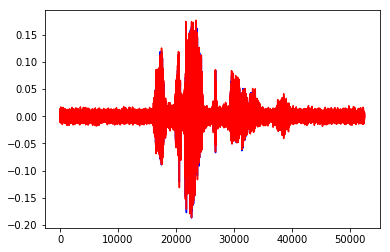

In [12]:
tfm_tester(example, tfm_add_white_noise)

## Volume Change

In [13]:
#Export
def tfm_modulate_volume(ad:AudioData, lower_gain=.1, upper_gain=1.2, **kwargs)->AudioData:
    modulation = random.uniform(lower_gain, upper_gain)
    return AudioData(ad.sig * modulation, ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


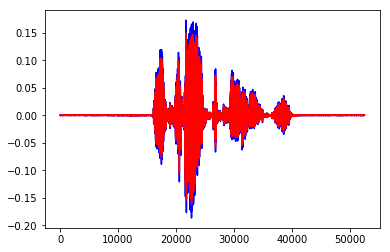

In [14]:
tfm_tester(example, tfm_modulate_volume)

## Random Cutout

In [15]:
#Export
def tfm_random_cutout(ad:AudioData, pct_to_cut=.15, **kwargs)->AudioData:
    """Randomly replaces `pct_to_cut` of signal with silence. Similar to grainy radio."""
    copy = ad.sig.clone()
    sig_len = copy.shape[0]
    sigs_to_cut = int(sig_len * pct_to_cut)
    for i in range(0, sigs_to_cut):
        cut_idx = random.randint(0, sig_len - 1)
        copy[cut_idx] = 0
    return AudioData(copy,ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


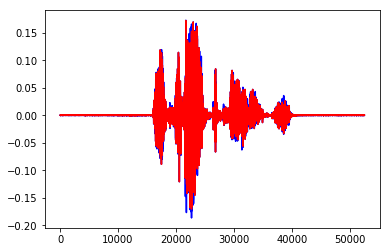

In [16]:
tfm_tester(example, partial(tfm_random_cutout,pct_to_cut=.95))

## Pad with Silence

In [17]:
#Export
def tfm_pad_with_silence(ad:AudioData, pct_to_pad=.15, min_to_pad=None, max_to_pad=None, **kwargs)->AudioData:
    """Adds silence to beginning or end of signal, simulating microphone cut at start of end of audio."""
    if max_to_pad is None: max_to_pad = int(ad.sig.shape[0] * 0.15)
    if min_to_pad is None: min_to_pad = -max_to_pad
    pad = random.randint(min_to_pad, max_to_pad)
    copy = ad.sig.clone()
    if pad >= 0: copy[0:pad] = 0
    else: copy[pad:] = 0
    return AudioData(copy,ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


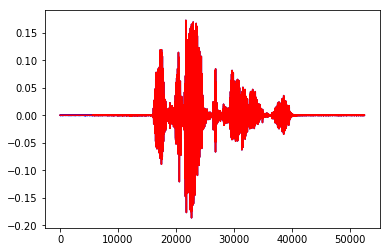

In [18]:
tfm_tester(example, tfm_pad_with_silence)

## Pitch Warp

In [19]:
#Export
def tfm_pitch_warp(ad:AudioData, shift_by_pitch=None, bins_per_octave=12, **kwargs)->AudioData:
    min_len = 600 # librosa requires a signal of length at least 500
    copy = ad.sig.clone()
    if (copy.shape[0] < min_len): copy = torch.cat((copy, torch.zeros(min_len - copy.shape[0])))
    if shift_by_pitch is None: shift_by_pitch = random.uniform(-3, 3)
    sig = torch.tensor(librosa.effects.pitch_shift(np.array(copy), ad.sr, shift_by_pitch, bins_per_octave))
    return AudioData(sig,ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


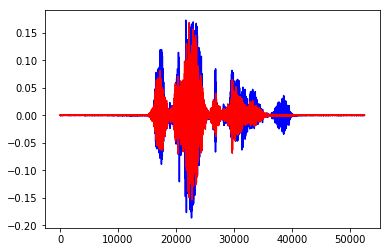

In [20]:
tfm_tester(example, partial(tfm_pitch_warp, shift_by_pitch=10))

## Lossy Downsample and Upsample

In [21]:
#Export
def tfm_down_and_up(ad:AudioData, sr_divisor=2, **kwargs)->AudioData:
    copy = np.array(ad.sig.clone())
    down = librosa.audio.resample(copy, ad.sr, ad.sr/sr_divisor)
    sig = torch.tensor(librosa.audio.resample(down, ad.sr/sr_divisor, ad.sr))
    return AudioData(sig,ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


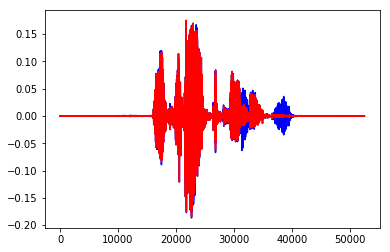

In [22]:
tfm_tester(example, tfm_down_and_up)

## Signal Mixup

In [23]:
#Export
def tfm_signal_mixup(signal, **kwargs):
    pass

## Combined Augmentations

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


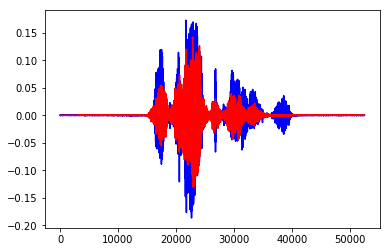

In [24]:
tfm_tester(example, [tfm_down_and_up, tfm_pitch_warp, tfm_pad_with_silence])

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


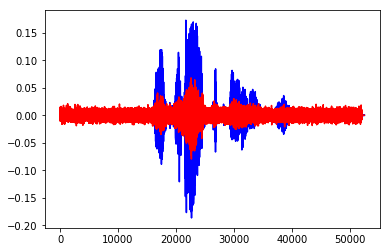

In [25]:
tfm_tester(example, [tfm_modulate_volume, tfm_pitch_warp, tfm_add_white_noise, tfm_pad_with_silence])

In [26]:
# Other stuff to possibly explore
# AudioSegment(…).overlay()
# AudioSegment(…).apply_gain(gain)
# AudioSegment(…).invert_phase()
# AudioSegment(…).set_sample_width()

# Generic Transforms

### Pad to maximum value (resize)

In [27]:
#Export
def tfm_pad_to_max(ad:AudioData, mx=1000):
    """Pad tensor with zeros (silence) until it reaches length `mx`"""
    copy = ad.sig.clone()
    if (copy.shape[0] < mx): copy = torch.cat((copy, torch.zeros(mx - copy.shape[0])))
    if (copy.shape[0] > mx): copy = copy[:mx]
    return AudioData(copy, ad.sr)

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


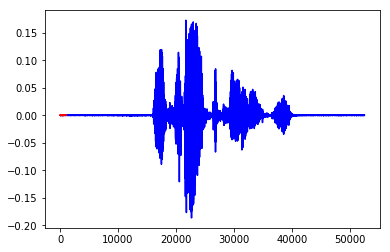

In [28]:
tfm_tester(example, partial(tfm_pad_to_max))

sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


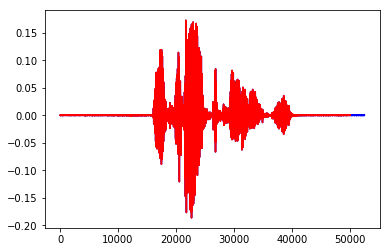

In [29]:
tfm_tester(example, partial(tfm_pad_to_max, mx=50000))

### Log input type and properties

In [30]:
#Export
def tfm_log(x, show=False, logOnlyFirst=True, msg=''):
    '''Fake transformation that logs x shape'''
    #TODO: implements the optional "show" and "logOnlyFirst"
    if isinstance(x,AudioData): print(f'{msg}{type(x).__name__} >> Shape of signal: {x.sig.shape}  sr: {x.sr}')
    elif hasattr(x,'shape'): print(f'{msg}{type(x).__name__} >> Shape: {x.shape}')
    else: print(f'{msg}{type(x).__name__}')
    return x

AudioData >> Shape of signal: torch.Size([52480])  sr: 16000
sr:16000   sig.shape:torch.Size([52480])


sr:16000   sig.shape:torch.Size([52480])


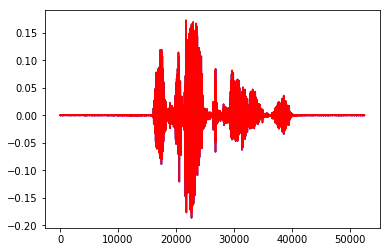

In [31]:
tfm_tester(example, tfm_log)

## External functions

### Amplitude to db
Librosa has a function that transforms a signal from amplitude to deciblel/db scale (amplitude_to_db).
Torchaudio seems to have the same functionality (SPEC2DB) but that functionality is not documented and not accessible for current torchaudio installatio.
Probably it will be added in the next version of the library (SPEC2DB is called by MEL2).
The following code is taken from the official torchaudio docs:
https://pytorch.org/audio/_modules/torchaudio/transforms.html

In [32]:
#Export

from torch.autograd import Variable

def _check_is_variable(tensor):
    if isinstance(tensor, torch.Tensor):
        is_variable = False
        tensor = Variable(tensor, requires_grad=False)
    elif isinstance(tensor, Variable):
        is_variable = True
    else:
        raise TypeError("tensor should be a Variable or Tensor, but is {}".format(type(tensor)))

    return tensor, is_variable

class SPEC2DB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.

    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is -80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        self.top_db = -top_db if top_db > 0 else top_db
        self.multiplier = 10. if stype == "power" else 20.

    def __call__(self, spec):

        spec, is_variable = _check_is_variable(spec)
        spec_db = self.multiplier * torch.log10(spec / spec.max())  # power -> dB
        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new([self.top_db]))
        return spec_db if is_variable else spec_db.data

## Formatting Transforms

In [33]:
#Export
def tfm_extract_signal(ad:AudioData):
    return ad.sig

In [34]:
#Export
def tfm_spectro(ad:AudioData, n_mels=128, to_db_scale=False, top_db=-80, **kwargs):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels, **kwargs)(ad.sig.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension...
    if to_db_scale: mel = SPEC2DB(stype='magnitude', top_db=top_db)(mel)
    return mel

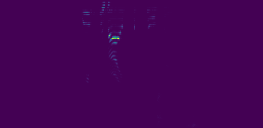

torch.Size([1, 128, 263])

In [35]:
img = Image(tfm_spectro(example, n_mels=128))
display(img, img.shape)

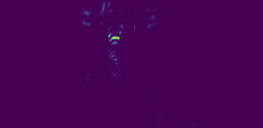

torch.Size([1, 128, 263])

In [36]:
#Default values...
img = Image(tfm_spectro(example, n_mels=128, ws=400, n_fft=1600))
display(img, img.shape)

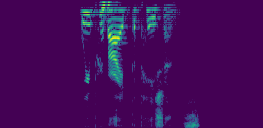

torch.Size([1, 128, 263])

In [37]:
img = Image(tfm_spectro(example, n_mels=128, to_db_scale=True))
display(img, img.shape)

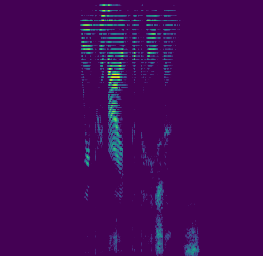

torch.Size([1, 256, 263])

In [38]:
img=tfm_spectro(example, n_mels=256, to_db_scale=True)
display(Image(img),img.shape)

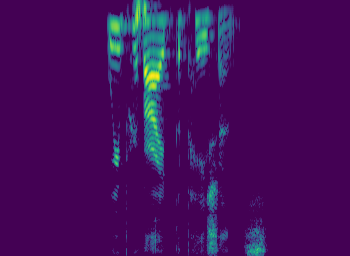

torch.Size([1, 256, 350])

In [39]:
img=tfm_spectro(example, n_mels=256, ws=300, n_fft=3200, to_db_scale=True)
display(Image(img),img.shape)

In [40]:
#Export
def tfm_spectro_stft(ad:AudioData, n_mels=128, n_fft=480, hop_length=160, win_length=480, window='hamming', **kwargs):
    #https://www.kaggle.com/haqishen/augmentation-methods-for-audio
    #https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    stft = librosa.stft(np.array(ad.sig), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    ret = torch.tensor(stft_magnitude_db)
    ret = ret.unsqueeze(0)
    return ret

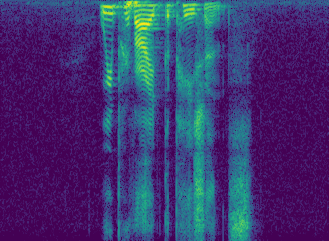

In [41]:
display(Image(tfm_spectro_stft(example)))

## Performance

### Transformations performance

In [42]:
%timeit -n100 tfm_add_white_noise(example)

462 µs ± 4.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%timeit -n100 tfm_modulate_volume(example)

21.3 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%timeit -n100 tfm_random_cutout(example)

52 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%timeit -n100 tfm_pad_with_silence(example)

37 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%timeit -n100 tfm_pitch_warp(example)

72.2 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit -n100 tfm_down_and_up(example)

**VERDICT:**<br>
Slow transformations are:
+ tfm_random_cutout 
+ tfm_pitch_warp  
+ tfm_down_and_up


### Spectrogram performance

In [ ]:
def getSpectroInDb_torchaudio(example):
    mel = tfm_spectro(example, n_mels=128)
    img = SPEC2DB(stype='magnitude', top_db=-80)(mel)
    return img
display(Image(getSpectroInDb_torchaudio(example)))

mel = tfm_spectro(example, n_mels=128)
%timeit SPEC2DB(stype='magnitude', top_db=-80)(mel)

In [ ]:
def getSpectroInDb_librosa(example):
    mel = tfm_spectro(example, n_mels=128)
    img = librosa.amplitude_to_db(np.array(mel))
    img = torch.tensor(img)
    return img
display(Image(getSpectroInDb_librosa(example)))

mel = tfm_spectro(example, n_mels=128)
%timeit torch.tensor(librosa.amplitude_to_db(np.array(mel)))

In [ ]:
def getSpectroInDb_torchaudio_cuda(example):
    mel = tfm_spectro(example, n_mels=128)
    img = SPEC2DB(stype='magnitude', top_db=-80)(mel)
    return img
display(Image(getSpectroInDb_torchaudio_cuda(example)))

mel = tfm_spectro(example, n_mels=128)
mel = mel.cuda()
%timeit SPEC2DB(stype='magnitude', top_db=-80)(mel)

**VERDICT:** 
The torchaudio on gpu is way faster than others...

# Export

In [ ]:
!python notebook2script.py DataAugmentation.ipynb